In [1]:
from typing import Union
import math

import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
import perceval.components as comp
from perceval.components.unitary_components import Unitary, BS, PS, StateVector, BasicState
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.utils.postselect import PostSelect

DisplayConfig.select_skin(SymbSkin)

In [2]:
# Input: parameters of the discriminator, starting index of first node, name of discrim
# Output: discriminator
def create_discriminator(discriminator_params, start_mode, called):
    pses = []
    for i in range(6):
        ps = PS(phi=pcvl.P(called + f'{i}'))
        ps.assign({called + f'{i}':discriminator_params[i]})
        pses.append(ps)
        
    
    discriminator = pcvl.Circuit(4, name=called)
    discriminator.add(start_mode, pses[0])
    discriminator.add(start_mode+1, pses[1])
    discriminator.add(start_mode+2, pses[2])
    discriminator.add(start_mode+0, BS())
    discriminator.add(start_mode+2, BS())
    discriminator.add(start_mode, pses[3])
    discriminator.add(start_mode+2, pses[4])
    discriminator.add(start_mode, BS())
    discriminator.add(start_mode+2, BS())
    discriminator.add(start_mode+1, BS())
    discriminator.add(start_mode+1, pses[5])
    discriminator.add(start_mode+1, BS())
    
    return discriminator

# Input: discriminator and new parameters
# What it does: changes directly value of discriminator
def set_params_discriminator(discriminator, new_params):
    params = discriminator.get_parameters()
    for i in range(6):
        params[i].set_value(new_params[i])

In [3]:
def create_generator(generator_params, start_mode, called):
    quantum_circuit = pcvl.Circuit(4, name=called)
    
    pses = []
    for i in range(15):
        ps = PS(phi=pcvl.P(called + f'{i}'))
        ps.assign({called + f'{i}':generator_params[i]})
        pses.append(ps)
    
    quantum_circuit.add(start_mode + 1, pses[0])
    quantum_circuit.add(start_mode + 2, pses[1])
    quantum_circuit.add(start_mode + 3, pses[2])

    quantum_circuit.add(start_mode + 1, BS())
    quantum_circuit.add(start_mode + 1, pses[7])
    quantum_circuit.add(start_mode + 1, BS())

    # env1
    quantum_circuit.add(start_mode, BS())
    quantum_circuit.add(start_mode, pses[3])
    quantum_circuit.add(start_mode, BS())
    quantum_circuit.add(start_mode+1, pses[4])

    quantum_circuit.add(start_mode + 2, BS())
    quantum_circuit.add(start_mode + 2, pses[8])
    quantum_circuit.add(start_mode + 2, BS())

    # env2
    quantum_circuit.add(start_mode + 1, BS())
    quantum_circuit.add(start_mode + 1, pses[5])
    quantum_circuit.add(start_mode + 1, BS())
    quantum_circuit.add(start_mode + 2, pses[6])

    quantum_circuit.add(start_mode, pses[9])

    quantum_circuit.add(start_mode, BS())
    quantum_circuit.add(start_mode + 2, BS())


    quantum_circuit.add(start_mode, pses[10])
    quantum_circuit.add(start_mode + 2, pses[11])

    quantum_circuit.add(start_mode, BS())
    quantum_circuit.add(start_mode + 2, BS())

    quantum_circuit.add(start_mode, pses[12])
    quantum_circuit.add(start_mode + 1, pses[13])
    quantum_circuit.add(start_mode + 2, pses[14])
    
    return quantum_circuit
    
def set_params_generator(generator, new_params):
    params = generator.get_parameters()
    for i in range(15):
        params[i].set_value(new_params[i])
        
def create_circuit(dis1, dis2, gen1, gen2, called):
    circuit = pcvl.Circuit(8, name=called)
    circuit.add(0, gen1)
    circuit.add(4, gen2)
    circuit.add(0, dis1)
    circuit.add(4, dis2)
    
    return circuit
    
    

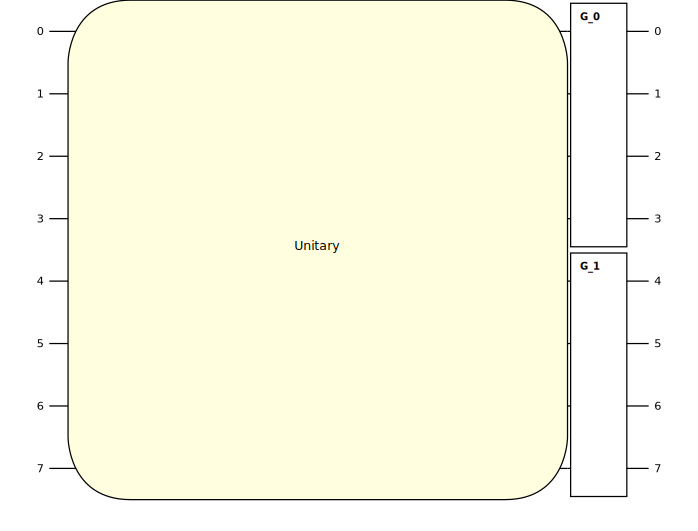

In [4]:
## Initialize our circuit
DISCRIM_SIZE = 6
GEN_SIZE = 15

disc_init1 = np.random.randint(0,2,size=(DISCRIM_SIZE))
disc_init2 = np.random.randint(0,2,size=(DISCRIM_SIZE))
gen_init1 = np.random.randint(0,2,size=(GEN_SIZE))
gen_init2 = np.random.randint(0,2,size=(GEN_SIZE))
discrim1 = create_discriminator(disc_init1,0,'d_0')
discrim2 = create_discriminator(disc_init2,0,'d_1')
gen1 = create_generator(gen_init1,0,'g_0')
gen2 = create_generator(gen_init2,0,'g_1')

tdiscrim = pcvl.Circuit(8)
tdiscrim.add(0, discrim1)
tdiscrim.add(4, discrim2)

tgen = pcvl.Circuit(8)

M = 1/math.sqrt(2) * pcvl.Matrix([[0, 0, 0, 0, 1, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0], 
                 [0, 1, 0, 1, 0, 0, 0, 0],
                 [1, 0, -1, 0, 0, 0, 0, 0],
                 [0, 1, 0, -1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, -1, 0],
                 [0, 0, 0, 0, 0, 1, 0, -1]])

c1 = comp.Unitary(U=M)
tgen.add(0, c1)
tgen.add(0, gen1)
tgen.add(4, gen2)


identity = pcvl.Circuit(8)

p_s = pcvl.Matrix(discrim1.U)
p_i = pcvl.Matrix(discrim2.U)
M_hat = np.kron(p_s, p_i)

rho_hat = pcvl.Matrix(tgen.U)

pcvl.pdisplay(tgen)
#pcvl.pdisplay(rho_hat)

In [7]:
initial_sv = StateVector("|1, 0, 0, 0, 1, 0, 0, 0>") + StateVector("|0, 1, 0, 0, 0, 1, 0, 0>")
true_sv = StateVector("|1,0,0,0,0,1,0,0>") + StateVector("|0,1,0,0,0,0,1,0>") + StateVector("|0,0,1,0,0,0,0,1>") + StateVector("|0,0,0,1,1,0,0,0>")

proc1 = pcvl.Processor("SLOS", tgen)
probs1 = np.array([0,0,0,0,0,0,0,0])
for i in range(1000):  
    ps = PostSelect("[0,1,2,3] == 1")
    proc1.with_input(initial_sv)
    proc1.set_postselection(ps) 
    sampler = pcvl.algorithm.Sampler(proc1)
    samples1 = sampler.samples(1)
    probability_distribution = sampler.probs()
    probs1 += np.array(samples1["results"][0])
probs1 = probs1/1000
print(probs1)


proc2 = pcvl.Processor("SLOS", identity)
proc2.with_input(true_sv)
sampler = pcvl.algorithm.Sampler(proc2)
samples2 = sampler.samples(1)
probability_distribution = sampler.probs()

print(np.array(samples1["results"]))
print(np.array(samples2["results"]))



[0.256 0.228 0.263 0.253 0.262 0.246 0.241 0.251]
[[0 0 1 0 0 0 0 1]]
[[0 1 0 0 0 0 1 0]]
